In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [22]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [23]:
# Get test split
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 1)


In [24]:
# Load model
experiments = ['imagery_sample_cnn_regression_baseline_NL']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [25]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-20 17:11:56.836511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[-3.6104143e+00]
 [-7.2387190e+00]
 [-4.8123565e+00]
 [-3.1010597e+00]
 [-3.4152710e+00]
 [-3.3737781e+00]
 [-2.9204390e+00]
 [-3.6064305e+00]
 [-3.2866049e+00]
 [-2.7692647e+00]
 [-2.5765111e+00]
 [-3.8014624e+00]
 [-3.7965233e+00]
 [-4.3471990e+00]
 [-3.1572559e+00]
 [-2.8949015e+00]
 [-3.2083964e+00]
 [-4.0581388e+00]
 [-3.5454261e+00]
 [-2.5682459e+01]
 [-3.0562332e+00]
 [-7.2387190e+00]
 [-3.2258470e+00]
 [ 3.1925895e-04]
 [-3.5851181e+00]
 [-4.2035894e+00]
 [-2.4853277e+00]
 [-3.9801230e+00]
 [-3.3942504e+00]
 [-2.1710534e+00]
 [-4.2504721e+00]
 [-3.0807536e+00]
 [-7.6173788e-01]
 [-2.0302589e+00]
 [-3.5947428e+00]
 [-3.4373953e+00]
 [-4.0656252e+00]
 [-3.7175019e+00]
 [-3.7717440e+00]
 [-6.5700692e-01]
 [-4.0602980e+00]
 [-4.8626842e+00]
 [-4.4830429e+01]
 [-4.0610948e+00]
 [-2.1850946e+00]
 [-2.3601692e+00]
 [-2.5618079e+00]
 [-2.3601692e+00]
 [-5.6667709e+01]
 [-3.9059303e+00]
 [-3.6096957e+00]
 [-3.4327421e+00]
 [-4.1368246e+00]
 [-3.3564835e+00]
 [-3.0019476e+00]
 [-7.61737

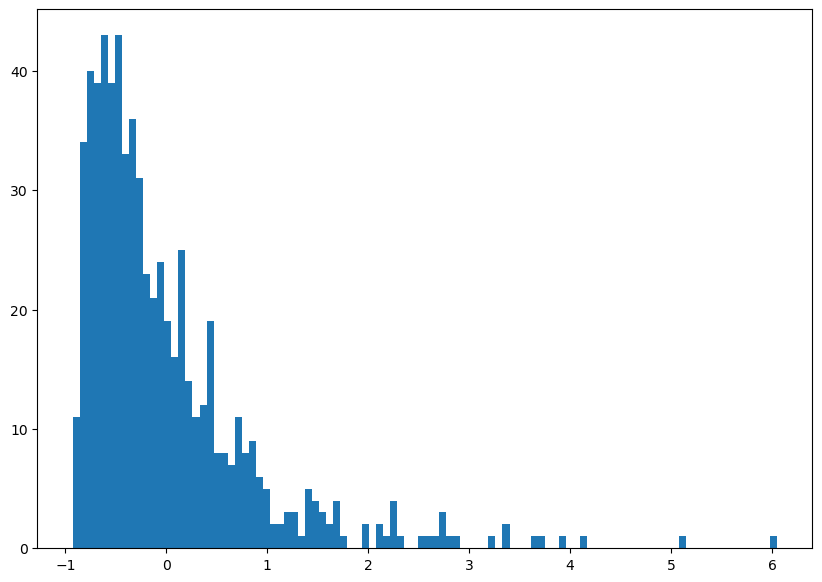

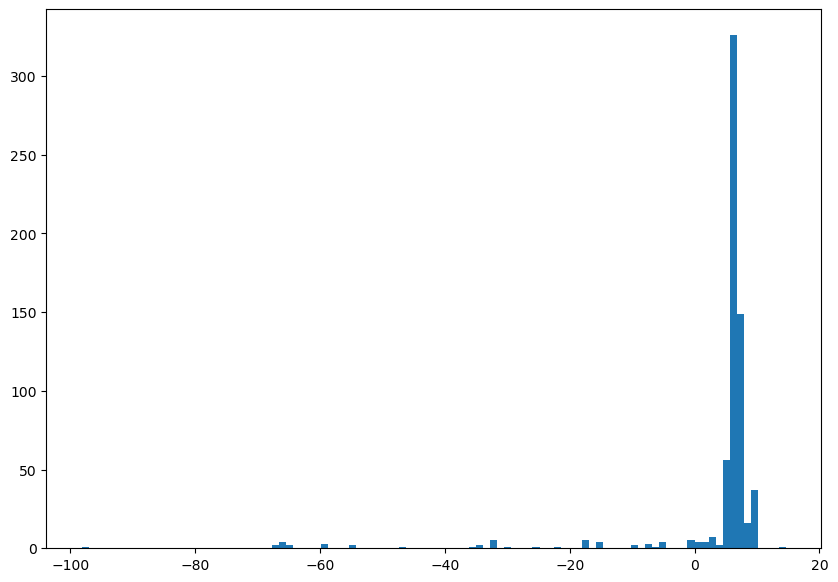

In [26]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds + 10

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()



r2 = pearsonr(y_true, y_preds)[0]

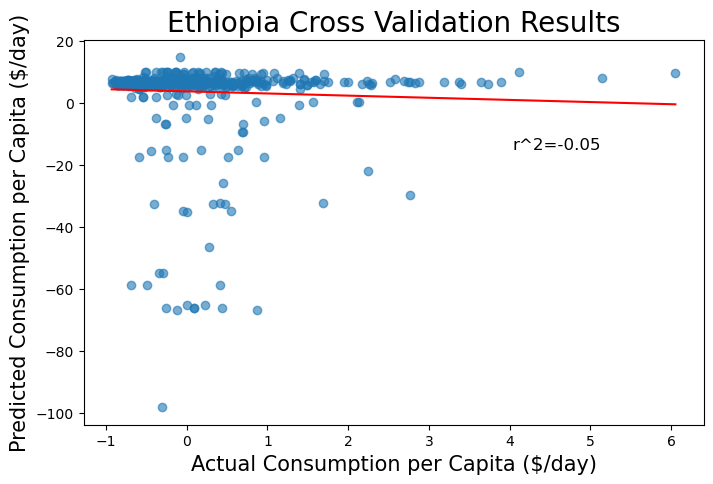

In [27]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()